In [1]:
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
proj_dim = 9728
proj_dim

9728

In [3]:
import matplotlib.pyplot as plt

In [4]:
from datasets import load_dataset

In [5]:
data_path = "data/alpaca_data_gpt4.json"
if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    dataset = load_dataset("json", data_files=data_path)
else:
    dataset = load_dataset(data_path)

In [6]:
df = pd.DataFrame(dataset['train'])
df.head()

,instruction,input,output
0,Give three tips for staying healthy.,,"1. Eat a balanced and nutritious diet: Make sure your meals are inclusive of a variety of fruits and vegetables, lean protein, whole grains, and healthy fats. This helps to provide your body with the essential nutrients to function at its best and can help prevent chronic diseases.\n\n2. Engage in regular physical activity: Exercise is crucial for maintaining strong bones, muscles, and cardiovascular health. Aim for at least 150 minutes of moderate aerobic exercise or 75 minutes of vigorous exercise each week.\n\n3. Get enough sleep: Getting enough quality sleep is crucial for physical and mental well-being. It helps to regulate mood, improve cognitive function, and supports healthy growth and immune function. Aim for 7-9 hours of sleep each night."
1,What are the three primary colors?,,"The three primary colors are red, blue, and yellow. These colors are called primary because they cannot be created by mixing other colors and all other colors can be made by combining them in various proportions. In the additive color system, used for light, the primary colors are red, green, and blue (RGB)."
2,Describe the structure of an atom.,,"An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center surrounded by a cloud of electrons.\n\nThe nucleus of an atom is made up of protons and neutrons. Protons are positively charged particles and neutrons are neutral particles with no charge. Both of these particles are located in the nucleus of the atom, which is at the center of the atom and contains most of the atom's mass.\n\nSurrounding the nucleus of the atom is a cloud of electrons. Electrons are negatively charged particles that are in constant motion around the nucleus. The electron cloud is divided into shells or orbitals, and each shell can hold a certain number of electrons. The number of electrons in the outermost shell, called the valence shell, determines the chemical properties of the atom. \n\nIn a neutral atom, the number of protons in the nucleus is equal to the number of electrons in the electron cloud, so the positive and negative charges balance out and the atom has no overall charge. The number of protons, also called the atomic number, determines what element the atom is."
3,How can we reduce air pollution?,,"There are several ways to reduce air pollution, including:\n\n1. Reduce energy consumption: By conserving energy, we reduce the amount of pollution emitted from power plants. Some ways to achieve this include: using energy-efficient appliances and lighting, insulating homes, and shutting off lights and electronics when not in use.\n\n2. Use public transportation or carpool: Cars and trucks are major sources of pollution. By using public transportation, carpooling or biking, you can reduce the number of cars on the road, which in turn reduces emissions.\n\n3. Be responsible with waste: When waste is burned or decomposed, they can release harmful gases into the air. Dispose of hazardous waste correctly and recycle materials like plastics, paper, and glass when possible.\n\n4. Support clean energy sources: Renewable energy sources like solar and wind power generate little or no pollution. Support clean energy companies and projects, and consider installing renewable energy systems in your home.\n\n5. Drive efficiently: If you need to drive, make sure your vehicle is well maintained and drive efficiently by avoiding rapid acceleration and braking, and reducing idling.\n\n6. Be mindful of product choices: Some products and practices release more pollution than others. Choose products with eco-friendly packaging and try to minimize your use of aerosol sprays, which can release harmful chemicals into the air."
4,Describe a time when you had to make a difficult decision.,,"As an AI assistant, I do not have my own personal 

In [7]:
k = len(df)
df_train = df.iloc[0:k].copy()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52002 entries, 0 to 52001
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  52002 non-null  object
 1   input        52002 non-null  object
 2   output       52002 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [8]:
dstore_keys = np.memmap('./saved/train_keys.npy', 
                        dtype=np.float16, 
                        mode='r',
                        shape=(52002, 9728))
dstore_keys[0:5]

memmap([[  3.127  ,   4.562  ,  23.12   , ..., -11.91   ,   2.809  ,
           7.363  ],
        [  5.883  ,  -4.64   ,  20.69   , ..., -13.984  ,   1.026  ,
           4.668  ],
        [  3.94   ,  -4.68   ,  15.516  , ..., -10.24   ,  -0.607  ,
           7.09   ],
        [  1.311  ,   0.04712,  15.805  , ..., -11.086  ,   2.748  ,
           4.98   ],
        [ -0.0815 ,  -2.094  ,  12.82   , ..., -10.59   ,   1.04   ,
           5.97   ]], dtype=float16)

In [9]:
dstore_keys[0:64]

memmap([[  3.127 ,   4.562 ,  23.12  , ..., -11.91  ,   2.809 ,   7.363 ],
        [  5.883 ,  -4.64  ,  20.69  , ..., -13.984 ,   1.026 ,   4.668 ],
        [  3.94  ,  -4.68  ,  15.516 , ..., -10.24  ,  -0.607 ,   7.09  ],
        ...,
        [  4.543 ,  -4.77  ,  12.74  , ..., -13.19  ,  11.22  ,  -0.3716],
        [  1.211 ,  -9.23  ,  15.695 , ..., -24.2   ,   0.66  ,   1.638 ],
        [  4.12  ,  -0.1613,  10.94  , ..., -11.32  ,   8.945 ,  -0.6255]],
       dtype=float16)

In [10]:
dstore_keys = dstore_keys[0:k].astype(np.float32)

In [11]:
gen_dstore_keys = dstore_keys # here we simple take the training examples as test examples

In [12]:
TracIn_score = (gen_dstore_keys/np.linalg.norm(gen_dstore_keys, axis=-1).reshape(-1, 1)).dot(
    (dstore_keys/np.linalg.norm(dstore_keys, axis=-1).reshape(-1, 1)).T)
TracIn_score.shape

(52002, 52002)

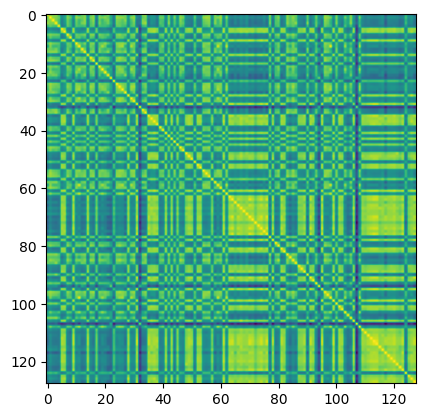

In [13]:
plt.imshow(TracIn_score[0:128, 0:128])

In [14]:
kernel = dstore_keys.T@dstore_keys
kernel = kernel.conjugate()
print(kernel.shape)

(9728, 9728)


In [15]:
lamb = 1e0 # you can adjust the lambda to tune the regularization effect
kernel_ = np.linalg.inv(kernel + lamb*np.eye(kernel.shape[0]))
print(kernel_.shape)
print(np.mean(kernel_.diagonal()))

(9728, 9728)
1.3379245239014158e-05


In [16]:
####
dstore_keys_ = dstore_keys@kernel_
####
TRAK_score = gen_dstore_keys.dot(dstore_keys_.T)
TRAK_score.shape

(52002, 52002)

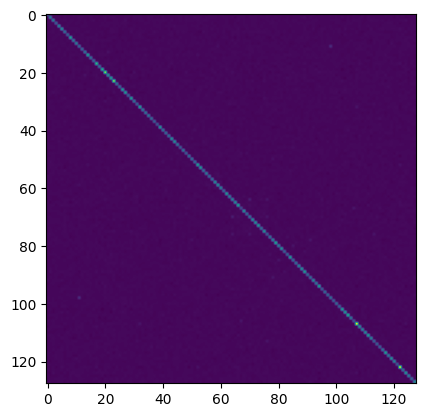

In [17]:
plt.imshow(TRAK_score[0:128, 0:128])

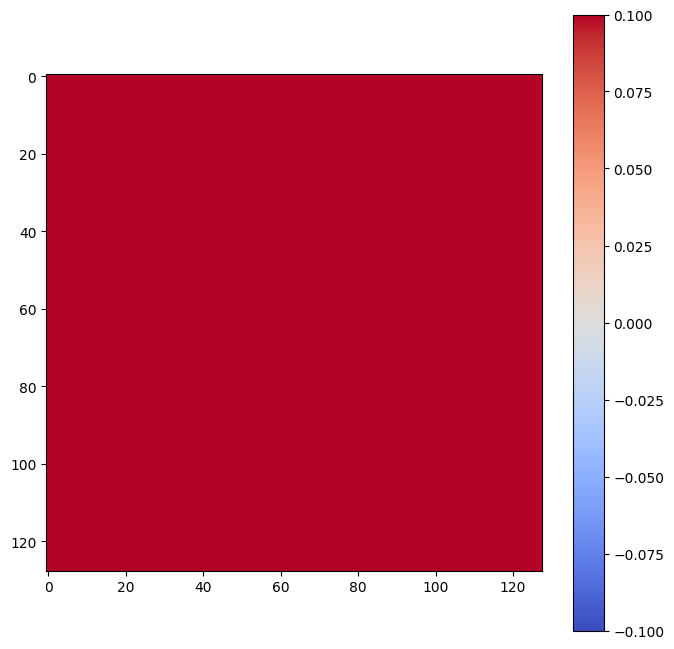

In [18]:
plt.figure(figsize = (8, 8))
plt.imshow(TracIn_score[0:128, 0:128], cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()

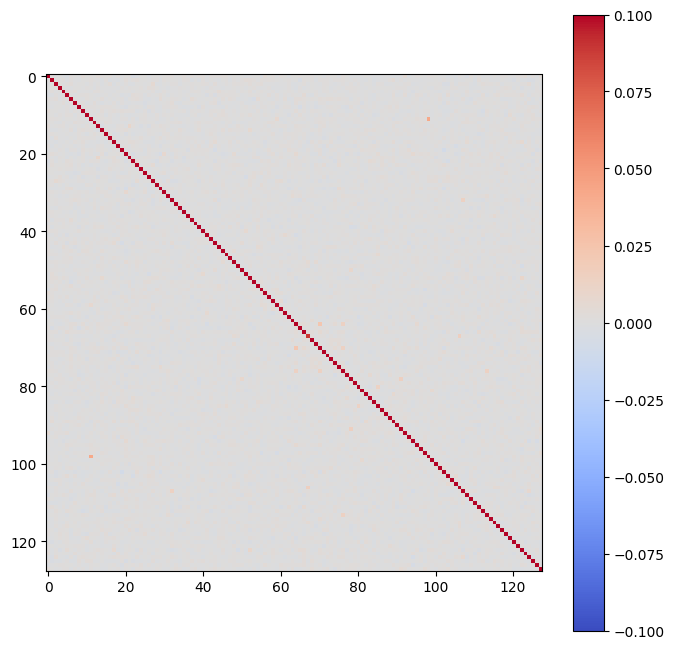

In [19]:
plt.figure(figsize = (8, 8))
plt.imshow(TRAK_score[0:128, 0:128], cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()

Text(0.5, 1.0, 'Memorization (Self-Infl.)')

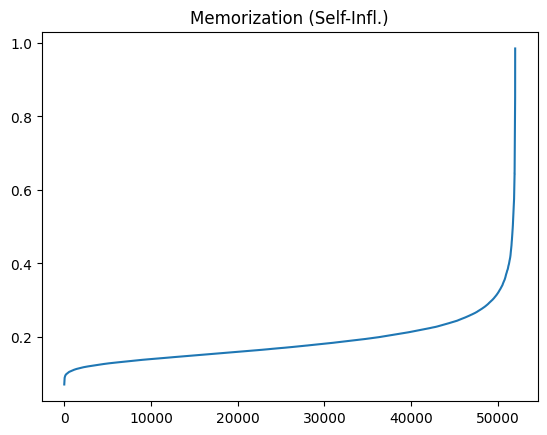

In [20]:
plt.plot(sorted(TRAK_score.diagonal()) )
plt.title('Memorization (Self-Infl.)')

In [21]:
df_train['mem_score'] = TRAK_score.diagonal()

In [22]:
df_train.sort_values(by=['mem_score'], ascending=False).head(16)

,instruction,input,output,mem_score
14522,Identify the elements of the below sentence structure.,We should take the time to appreciate our surroundings.,Subject: We\nModal verb: should \nMain verb: take \nObject: the time \nInfinitive phrase: to appreciate \nDirect object: our surroundings.,0.984789
17530,Come up with a 3-step recipe to roast vegetables.,,"Roasting vegetables is a simple yet delicious way to highlight the natural flavors and textures of your favorite veggies. Here's a simple 3-step recipe you can follow:\n\n1. Preheat your oven to 425 degrees F (220 degrees C). Cut your vegetables into equal sizes and place them in a large bowl. You can use any combination of vegetables you like, such as carrots, squash, potatoes, sweet potatoes, bell peppers, onions, and mushrooms.\n\n2. Drizzle the vegetables with olive oil and toss to coat. Sprinkle with salt, pepper, and any other seasonings you enjoy, such as garlic powder, dried herbs, or paprika. Mix well to evenly distribute the seasoning.\n\n3. Spread the vegetables out in a single layer on a large baking sheet. Roast for 25-30 minutes, until tender and lightly browned. Toss the vegetables halfway through cooking for even roasting. Serve immediately and enjoy your delicious, healthy, and flavorful roasted vegetables.",0.965194
50912,Name three industrial products that use AI.,,"Three industrial products that incorporate AI are:\n\n1. Industrial Robots: These are intelligent machines that leverage AI technologies to automate repetitive and strenuous tasks in industries such as manufacturing, assembly, and packaging.\n\n2. Predictive Maintenance Systems: These systems use advanced algorithms and AI models to predict when industrial machinery requires maintenance, reducing downtime and optimizing the performance of industrial equipment.\n\n3. Machine Vision Systems: These systems use AI-based image analysis to detect defects, guide robotic operations, and perform quality inspections in manufacturing and the production of goods.",0.953458
15376,Describe life in the given city.,Los Angeles,"Life in Los Angeles can be described as vibrant, fast-paced, and full of endless opportunities. Known for its sunny weather, the city boasts of picturesque beaches, mountains, and stunning landscapes that are a sight to behold. The region is the entertainment capital of the world, and its residents enjoy a diverse range of leisure activities including surfing, hiking, and cultural sightseeing. \n\nLos Angeles is a sprawling city with a mix of neighborhoods that offer something to everyone. From the glitz and glamour of Hollywood to the laid-back vibe of Santa Monica, there is never a dull moment in this city. The food scene is diverse and exciting, with a wide range of options from street-side tacos to high-end dining experiences.\n\nThe city is also known for its notorious traffic, and residents often have to contend with long commutes. Public transportation is available, but most people prefer to drive. The cost of living is relatively high, with housing being the most significant expense for most residents.\n\nOverall, life in Los Angeles is dynamic, and the city offers a unique blend of excitement, opportunity, and diversity.",0.929546
42313,Say the alphabet backward.,,"Z, Y, X, W, V, U, T, S, R, Q, P, O, N, M, L, K, J, I, H, G, F, E, D, C, B, A.",0.875673
18801,Rewrite the given sentence to convey the same sentiment with different words,This is a thoroughly fascinating experience,This experience is intriguing to an immense degree.,0.857390
34410,Generate a science fiction story based on the following material.,,"As the sun began to set behind the towering skyscrapers of the city, a young girl named Sara stood on the rooftop of her apartment building, staring up at the night sky. For as long as she could remember, she had been fascinated by the stars and the mysteries of the universe. She often dreamt of leaving Earth and traveling to other worlds, discovering new forms of life and 

In [30]:
i = 2 # training example index

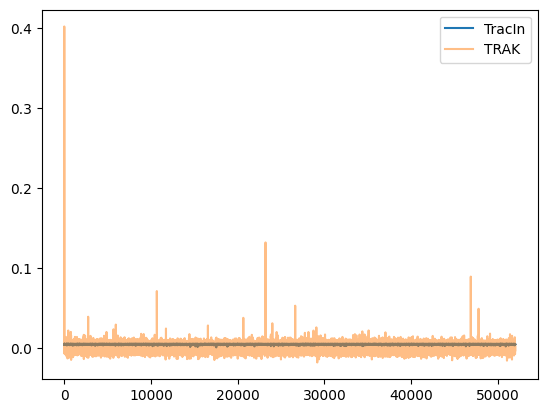

In [31]:
plt.plot(TracIn_score[i] / np.linalg.norm(TracIn_score[i]), label='TracIn')
plt.plot(TRAK_score[i] / np.linalg.norm(TRAK_score[i]), label='TRAK', alpha=0.5)
plt.legend()

In [32]:
df_train.iloc[i:i+1]

,instruction,input,output,mem_score,tracin_score,trak_score
2,Describe the structure of an atom.,,"An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center surrounded by a cloud of electrons.\n\nThe nucleus of an atom is made up of protons and neutrons. Protons are positively charged particles and neutrons are neutral particles with no charge. Both of these particles are located in the nucleus of the atom, which is at the center of the atom and contains most of the atom's mass.\n\nSurrounding the nucleus of the atom is a cloud of electrons. Electrons are negatively charged particles that are in constant motion around the nucleus. The electron cloud is divided into shells or orbitals, and each shell can hold a certain number of electrons. The number of electrons in the outermost shell, called the valence shell, determines the chemical properties of the atom. \n\nIn a neutral atom, the number of protons in the nucleus is equal to the number of electrons in the electron cloud, so the positive and negative charges balance out and the atom has no overall charge. The number of protons, also called the atomic number, determines what element the atom is.",0.161665,0.922344,0.000757


In [33]:
df_train['tracin_score'] = TracIn_score[i]
df_train['trak_score'] = TRAK_score[i]

In [34]:
df_train.sort_values(by=['tracin_score'], ascending=False).head(16)

,instruction,input,output,mem_score,tracin_score,trak_score
2,Describe the structure of an atom.,,"An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center surrounded by a cloud of electrons.\n\nThe nucleus of an atom is made up of protons and neutrons. Protons are positively charged particles and neutrons are neutral particles with no charge. Both of these particles are located in the nucleus of the atom, which is at the center of the atom and contains most of the atom's mass.\n\nSurrounding the nucleus of the atom is a cloud of electrons. Electrons are negatively charged particles that are in constant motion around the nucleus. The electron cloud is divided into shells or orbitals, and each shell can hold a certain number of electrons. The number of electrons in the outermost shell, called the valence shell, determines the chemical properties of the atom. \n\nIn a neutral atom, the number of protons in the nucleus is equal to the number of electrons in the electron cloud, so the positive and negative charges balance out and the atom has no overall charge. The number of protons, also called the atomic number, determines what element the atom is.",0.161665,1.000000,0.161665
10601,Describe the heat transfer process.,,"Heat transfer refers to the process of moving heat from one body or system to another. It takes place as a result of a temperature difference and is governed by the laws of thermodynamics. There are three primary modes of heat transfer: conduction, convection, and radiation.\n\nConduction is the transfer of heat between two objects in direct contact with one another. The heat flows from the hotter body to the cooler one as the fast-moving molecules of the hotter body collide with the slower-moving molecules of the cooler body, transferring their energy. This mode of heat transfer is most commonly seen in solids, as they have tightly packed molecules that facilitate the transfer of heat.\n\nConvection, on the other hand, involves the transfer of heat through the motion of a fluid. In natural convection, the heat causes the fluid to become less dense, and this lighter fluid rises. Cooler and denser fluid then takes its place, creating a current that transfers heat away from the source. Forced convection involves the movement of fluid by an external source such as a fan or pump.\n\nRadiation involves the transfer of heat through electromagnetic waves. It is the only mode of heat transfer that does not require a medium and can take place in a vacuum. All bodies emit thermal radiation, with hotter bodies emitting more radiation than cooler ones.\n\nIn summary, heat transfer is the process of thermal energy flowing from a hotter body to a cooler one, through conduction, convection, or radiation, until thermal equilibrium is achieved.",0.124922,0.942188,0.003167
757,Identify and define the parts of a cell.,,"A cell is the basic structural and functional unit of all living organisms. Each cell is made up of different parts or organelles, each of which performs a specific function necessary for the cell to survive. Some of the main parts of a cell include the following:\n\n1. Cell Membrane: Also known as the plasma membrane, this is an outer covering that forms the boundary between the cell's internal environment and the external environment. It is selectively permeable, meaning that it regulates the exchange of materials between the cell and its surroundings.\n\n2. Cytoplasm: This is a jelly-like substance that fills the cell and contains all other organelles. It is composed of water, proteins, carbohydrates, and other molecules, and is the site of many biochemical reactions that occur within the cell.\n\n3. Nucleus: This is a membrane-bound organelle that contains the cell's genetic material in the form of DNA. The nucleus regulates all cellular activity by directing protein synthesi

In [35]:
# You can see trak is better than tracin!
df_train.sort_values(by=['trak_score'], ascending=False).head(16)

,instruction,input,output,mem_score,tracin_score,trak_score
2,Describe the structure of an atom.,,"An atom is the basic building block of all matter and is made up of three types of particles: protons, neutrons, and electrons. The structure of an atom can be described as a nucleus at the center surrounded by a cloud of electrons.\n\nThe nucleus of an atom is made up of protons and neutrons. Protons are positively charged particles and neutrons are neutral particles with no charge. Both of these particles are located in the nucleus of the atom, which is at the center of the atom and contains most of the atom's mass.\n\nSurrounding the nucleus of the atom is a cloud of electrons. Electrons are negatively charged particles that are in constant motion around the nucleus. The electron cloud is divided into shells or orbitals, and each shell can hold a certain number of electrons. The number of electrons in the outermost shell, called the valence shell, determines the chemical properties of the atom. \n\nIn a neutral atom, the number of protons in the nucleus is equal to the number of electrons in the electron cloud, so the positive and negative charges balance out and the atom has no overall charge. The number of protons, also called the atomic number, determines what element the atom is.",0.161665,1.000000,0.161665
23210,Answer the following question on the structure of the atom.,What is the basic structure of an atom?,"An atom is the basic unit of matter and consists of three main types of particles: protons, neutrons, and electrons. These particles are arranged in a specific structure. At the center of an atom is a dense nucleus, which contains protons and neutrons. Protons have a positive electrical charge, while neutrons have no charge. Surrounding the nucleus is a cloud-like region of space filled with electrons, which have a negative electrical charge. These electrons are arranged in shells or energy levels and are constantly moving around the nucleus. The number of protons, neutrons, and electrons and their specific arrangement within an atom determine the element's chemical properties.",0.144908,0.807389,0.053018
46881,What is the third major component of an atom?,,"The third major component of an atom is electron. An atom is composed of three major types of subatomic particles: protons, neutrons, and electrons. Protons and neutrons are found in the nucleus at the center of the atom, while electrons move around the nucleus in orbits known as electron shells.",0.210262,0.933761,0.035825
10674,Are atoms made up of protons and neutrons?,,"Yes, atoms are made up of protons, neutrons, and electrons. The protons and neutrons are located in the nucleus at the center of the atom, while the electrons orbit the nucleus in shells or energy levels. The number of protons determines the element’s atomic number and its position in the periodic table. The number of neutrons can vary to produce isotopes of an element, which have the same atomic number but different mass numbers. The number of electrons in an atom is equal to the number of protons, giving the atom a neutral overall charge.",0.193743,0.927785,0.028550
26632,Construct a model of an atom,,"An atom can be modeled as a tiny, dense nucleus made up of protons and neutrons, surrounded by a cloud of electrons. Here is a step-by-step guide to help you construct a model of an atom:\n\n1. Identify the element: First, you need to know what element you are building the model for. Each element has a unique number of protons, neutrons, and electrons.\n\n2. Gather materials: To construct your model, you will need a variety of materials such as styrofoam balls, pipe cleaners, paint, and glue. You can use the styrofoam balls to represent protons, neutrons, and electrons, and the pipe cleaners to represent the electron orbits.\n\n3. Paint the nucleus: Start by painting the styrofoam balls that are representing the protons and neutrons. Protons are often painted red and neutrons are painted blu

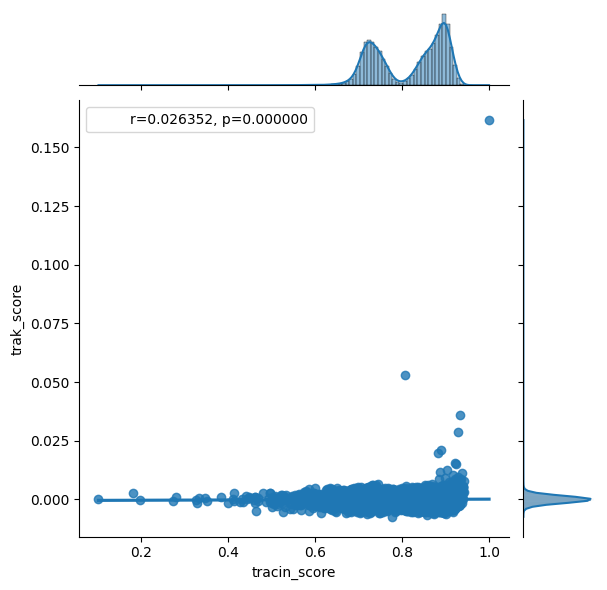

In [36]:
import seaborn as sns
from scipy import stats

graph = sns.jointplot(df_train, x='tracin_score', y='trak_score', kind='reg')

r, p = stats.pearsonr(df_train['tracin_score'], df_train['trak_score'])

phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
graph.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])